In [93]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from string import punctuation, digits, whitespace

### **Bilioteka umożliwiająca na lematyzację tekstu**

In [94]:
import morfeusz2
morf = morfeusz2.Morfeusz()

### **Pobieranie stron html, które zawierają poszczególne informacje o wybranych dietach**

In [95]:
diet_names = ['śródziemnomorska', 'dukan', 'wegańska', 'fleksitariańska', 'ketogeniczna']

In [96]:
diet_pages = {}

with open('diety-urls.txt', 'r', encoding='utf-8') as urls_file:
    urls_list = urls_file.readlines()
    urls_list_cleaned = [line.strip('\n') for line in urls_list]

    for diet_name, url in zip(diet_names, urls_list_cleaned):
        diet_page = requests.get(url)
        diet_pages[diet_name] = diet_page.content

### **Funkcje potrzebne do przekształcenia danych**

In [97]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [98]:
def define_range(start, end):
    return [i for i in range(start, end + 1)]

In [99]:
def chosing_products(lines_to_delete, products_list):

    chosen_products = []
    for index, element in enumerate(products_list):
        if index + 1 not in lines_to_delete:
            chosen_products.append(element)

    return chosen_products

In [100]:
def replace_products(replace_dict, products_list):
    for old, new in replace_dict.items():
        try:
            index = products_list.index(old)
        except ValueError:
            print(f'{old} not in list')
            continue
        else:
            products_list[index] = new
    return products_list

In [101]:
def remove_pre_of_suf(prefs_and_suffs, products_list):
    for strip in prefs_and_suffs:
        products_list = [product.removeprefix(strip).removesuffix(strip).strip() for product in products_list]
    return products_list

In [102]:
def write_graph_data(file_with_graph, diet_name, *, file_with_products=None, products_list=None):

    if file_with_products:
        with open(file_with_products, 'r', encoding='utf-8') as f:
            products_list = [product.strip() for product in f.readlines()]

    with open(file_with_graph, 'a', encoding='utf-8') as f:
        for index, product in enumerate(products_list):
            text = f"({diet_name}, {product})\n"
            f.write(text.lower())

In [103]:
def split_lines(list_of_lines, separators=[', ', ';', '; ', ' - ', " – ", ' i ', ':', " : ", ' lub ', ' oraz ', '.', ' czy ']):
    for sep in separators:
        list_of_lines = flatten([line.split(sep) for line in list_of_lines])
    return list_of_lines

In [104]:
def strip_punctors(list_of_words, punctors=f"{whitespace}{punctuation}{digits}"):
    return [word.strip(punctors).lower() for word in list_of_words]

In [105]:
def add_preffix(preffix, chosen_lines, products_list):
    return [f"{preffix} {product}" if index + 1 in chosen_lines else product for index, product in enumerate(products_list)]

In [106]:
with open('dieta-produkt.txt', 'w') as f:
    print('Wyszyszczono plik')

Wyszyszczono plik


### **Dieta środziemnomorska**

In [107]:
med_soup = BeautifulSoup(diet_pages['śródziemnomorska'])
raw_med = med_soup.select('li')
uls_med = [ul.get_text() for ul in raw_med][15:24]

In [108]:
splitted_med_products = split_lines(uls_med)
stripped_med_products = list(filter(None, strip_punctors(splitted_med_products)))
after_deleting_med_products = chosing_products([1, 34, 35, 52, 53, 65, 73, 74, 76, 80], stripped_med_products)
after_replace_med_products = replace_products({'czerwone winogrona':'winogrona',
                                               'laskowe': 'orzechy laskowe',
                                               'dobrej jakości sery': 'sery',
                                               'mleko o obniżonej zawartości tłuszczu' : 'mleko',
                                               'oliwa z oliwek z pierwszego tłoczenia' : 'oliwa z oliwek',
                                               'jogurt naturalny': 'jogurty',
                                               'jaja': 'jajka',
                                               'nasiona roślin strączkowych': 'rośliny strączkowe'}, after_deleting_med_products)

In [109]:
write_graph_data('dieta-produkt.txt', 'śródziemnomorska', products_list=list(set(after_replace_med_products)))

### **Dieta dukan**

In [110]:
dukan_soup = BeautifulSoup(diet_pages['dukan'])
raw_dukan = dukan_soup.select('h4 ~ p')
raw_dukan = [p.get_text() for p in raw_dukan][:8]

In [111]:
splitted_dukan_products = split_lines(raw_dukan)
stripped_dukan_products = list(filter(None, strip_punctors(splitted_dukan_products)))
after_deleting_dukan_products = chosing_products([1, 18, 19, 37, 43, 90, 91, 92, 94], stripped_dukan_products)
after_removing_pre_and_suff_dukan_products = remove_pre_of_suf(['beztłuszczowy', 'beztłuszczowe', 'beztłuszczowa',                                                                
                                                                'chuda', 'chude', 'niskotłuszczowe', 'świeże', 'świeży'], after_deleting_dukan_products)
after_replace_dukan_products = replace_products({'boczek sojowy': 'boczek',
                                                 'halibut (także wędzony': 'halibut',
                                                 'łosoś (także wędzony': 'łosoś',                                              
                                                 'okra (piżmian jadalny' : 'okra'}, after_removing_pre_and_suff_dukan_products)

In [112]:
write_graph_data('dieta-produkt.txt', 'dukan', products_list=list(set(after_replace_dukan_products)))

### **Dieta wegetariańska**

In [113]:
veg_soup = BeautifulSoup(diet_pages['wegańska'])
raw_veg = veg_soup.select('p ~ ul li')
raw_veg = [li.get_text() for li in raw_veg][6:11]

In [114]:
splitted_veg_products = split_lines(raw_veg)
stripped_veg_products = list(filter(None, strip_punctors(splitted_veg_products)))
after_deleting_veg_products = chosing_products([1, 2, 15, 16, 17, 18, 19, 20, 26, 27, 28, 36, 40, 41, 42,
                                               48, 49, 50, 55, 58, 61, 62, 63], stripped_veg_products)
after_replace_veg_products = replace_products({'\xa0owies': 'owies',
                                                 'takie jak komosa ryżowa': 'komosa ryżowa',
                                                 'jogurtu': 'jogurty',
                                                 'seitanu': 'seitan',
                                                 'łubinu': 'łubin',
                                                 'sera': 'sery'}, after_deleting_veg_products)
for preffix, indexes in zip(['wegańskie'], [define_range(35, 36)]):
    after_replace_veg_products = add_preffix(preffix, indexes, after_replace_veg_products)

In [115]:
write_graph_data('dieta-produkt.txt', 'wegańska', products_list=list(set(after_replace_veg_products)))

### **Dieta fleksitariańska**

In [116]:
fleksi_soup = BeautifulSoup(diet_pages['fleksitariańska'])
raw_fleksi = list(fleksi_soup.find_all('span'))
index_start, index_stop = None, None

for index, element in enumerate(raw_fleksi):
    if "Codziennie" in element.get_text():
        index_start = index + 1
    if "Dieta fleksitariańska – tego należy unikać" in element.get_text():
        index_stop = index

raw_fleksi =  [span.get_text() for span in raw_fleksi[index_start:index_stop]]

In [117]:
splitted_fleksi_products = split_lines(raw_fleksi)
stripped_fleksi_products = list(filter(None, strip_punctors(splitted_fleksi_products)))
after_deleting_fleksi_products = chosing_products([1, 18, 19, 20, 21, 22, 30, 55, 59, 67, 72, 73, 74, 75, 76, 85, 88], stripped_fleksi_products)
for preffix, indexes in zip(['płatki', 'kasza', 'mleko'], [define_range(7, 11), define_range(13, 14), define_range(45, 46)]):
    after_deleting_fleksi_products = add_preffix(preffix, indexes, after_deleting_fleksi_products)
after_replace_fleksi_products = replace_products({'czyli pieczywo razowe': 'pieczywo razowe',
                                                 'niesłodzone mleko migdałowe': 'mleko migdałowe',
                                                 'wegańskie jogurty': 'jogurty',
                                                 'mięso z indyka': 'indyk',
                                                 'mięso z kurczaka': 'kurczak',
                                                 'mleko migdałowe': 'mleko roślinne',
                                                 'płatki owsiane': 'owies',
                                                 'płatki orkiszowe': 'orkisz'}, after_deleting_fleksi_products)                                           

In [118]:
write_graph_data('dieta-produkt.txt', 'fleksitariańska', products_list=list(set(after_replace_fleksi_products)))

### **Dieta ketogeniczna**

In [119]:
keto_soup = BeautifulSoup(diet_pages['ketogeniczna'])
raw_keto = keto_soup.select('ul li')[134:184]
raw_keto = [ul.get_text() for ul in raw_keto]

In [120]:
splitted_keto_products = split_lines(raw_keto)
stripped_keto_products = list(filter(None, strip_punctors(splitted_keto_products)))
after_deleting_keto_products = chosing_products([53, 54, 55], stripped_keto_products)
for preffix, indexes in zip(['orzechy'], [define_range(28, 34)]):
    after_deleting_keto_products = add_preffix(preffix, indexes, after_deleting_keto_products)

In [121]:
words = []
for p in after_deleting_keto_products[13:19]:
    analysis = morf.analyse(p)

    for a in analysis:
        words.append(a[2][1])

words

['małż',
 'krewetka',
 'tuńczyk',
 'makrela',
 'makrela',
 'makrela',
 'łosoś',
 'śledź',
 'śledzić']

In [122]:
after_deleting_keto_products[13:19] = ['małże', 'krewetki', 'tuńczyk', 'makrela', 'łosoś', 'śledzie']

In [123]:
after_replace_keto_products = replace_products({'niektóre sery (np': 'sery',
                                                'pierś z kurczaka': 'kurczak',
                                                'pierś z indyka' : 'indyk',
                                                'brokuł': "brokuły"}, after_deleting_keto_products)

In [124]:
write_graph_data('dieta-produkt.txt', 'ketogeniczna', products_list=list(set(after_replace_keto_products)))

### **Wyświetlenie sieci**

In [125]:
with open('dieta-produkt.txt', 'r+', encoding='utf-8') as network_data:

       all_lines = network_data.readlines()
       connections_list = []
       
       for index, line in enumerate(all_lines):

          line = line.strip("\n()").lower()
          
          try:
               n1, n2 = line.split(", ")
          except ValueError:
               print(f"Nie udało się podzielić lini {index + 1}")
          else:
               connections_list.append((n1, n2))

In [126]:
from collections import Counter

In [127]:
products = [product for _, product in connections_list]
counted_products = Counter(products)
more_than_one = [product for (product, counter) in list(counted_products.items()) if counter > 1]

In [128]:
connections_list = [(diet, product) for diet, product in connections_list if product in more_than_one]

In [129]:
G = nx.Graph(connections_list)
nodes_colors = []
nodes_size = []

for node in G.nodes():
    
    if node in diet_names:
        nodes_colors.append('red')
        nodes_size.append(9000)
    else:
        nodes_colors.append('green')
        nodes_size.append(1100)

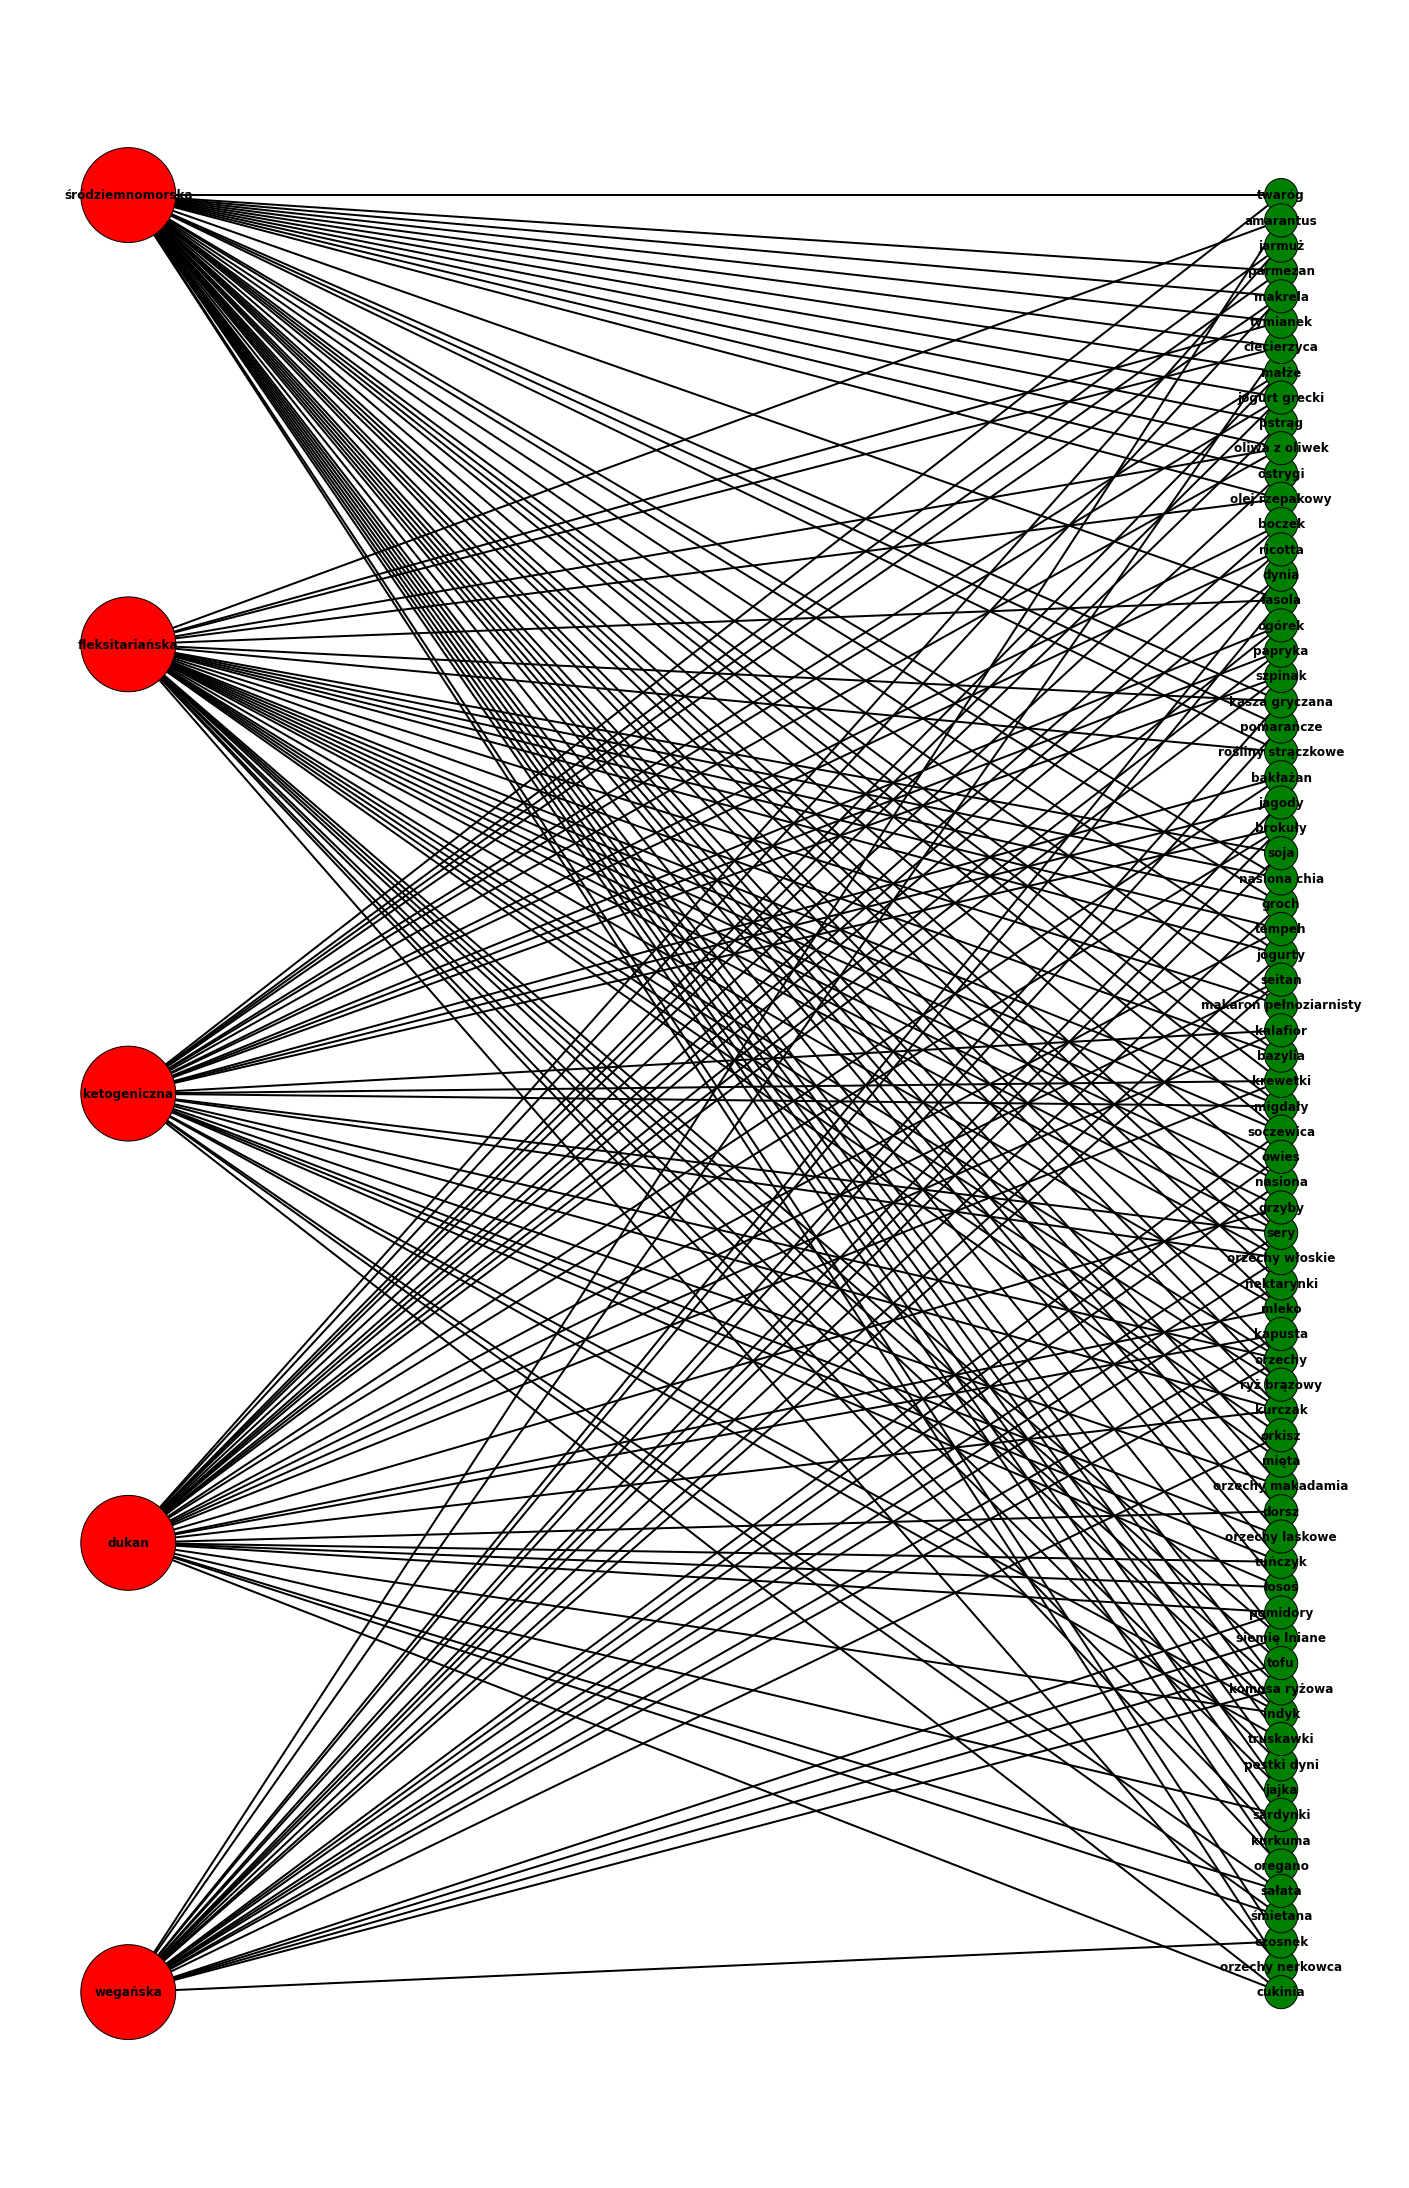

In [130]:
options = {
    'node_color': nodes_colors,
    'node_size': nodes_size,
    'width': 2,
    'edgecolors': 'black'
}
fig, ax = plt.subplots(figsize=(25, 40))
pos =  nx.bipartite_layout(G, diet_names)
ax = nx.draw(G, pos, with_labels=True, font_weight='bold', **options)
plt.show()

In [131]:
weighted_projection = nx.bipartite.weighted_projected_graph(G, diet_names, ratio=True)
newman_projection = nx.bipartite.collaboration_weighted_projected_graph(G, diet_names)
jaccard_projection = nx.bipartite.overlap_weighted_projected_graph(G, diet_names, jaccard=True)

In [132]:
weighted_projection_matrix = np.zeros((len(diet_names), len(diet_names)))
newman_projection_matrix = np.zeros((len(diet_names), len(diet_names)))
jaccard_projection_matrix = np.zeros((len(diet_names), len(diet_names)))

In [133]:
for projection_type, projection_matrix in zip([weighted_projection, newman_projection, jaccard_projection],
                                              [weighted_projection_matrix, newman_projection_matrix, jaccard_projection_matrix]):

    for index, (diet_1, diet_2, weight) in enumerate(list(projection_type.edges(data=True))):

        d1, d2 = diet_names.index(diet_1), diet_names.index(diet_2)
        projection_matrix[d1, d2] = round(weight['weight'], 4)
        projection_matrix[d2, d1] = round(weight['weight'], 4)

In [137]:
newman_projection_matrix = newman_projection_matrix / (np.sum(newman_projection_matrix) / 2)

In [138]:
newman_projection_matrix

array([[0.        , 0.0944125 , 0.09826567, 0.23892083, 0.12331417],
       [0.0944125 , 0.        , 0.052023  , 0.03660916, 0.17533717],
       [0.09826567, 0.052023  , 0.        , 0.121387  , 0.02890167],
       [0.23892083, 0.03660916, 0.121387  , 0.        , 0.03082883],
       [0.12331417, 0.17533717, 0.02890167, 0.03082883, 0.        ]])

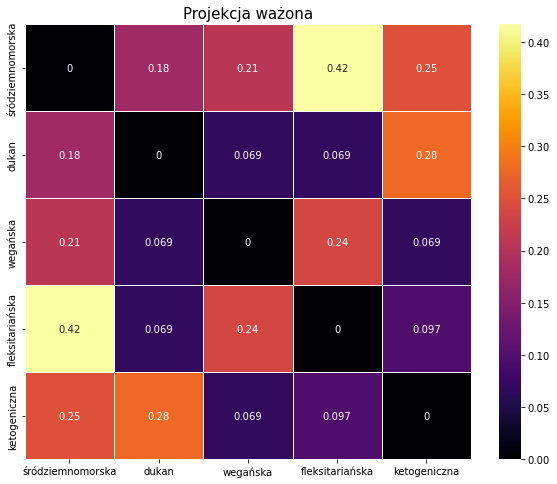

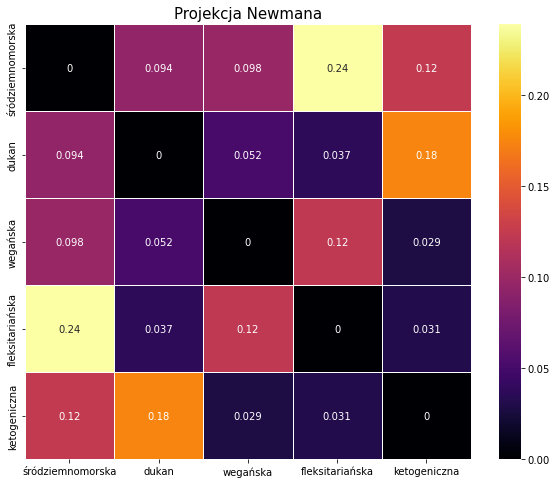

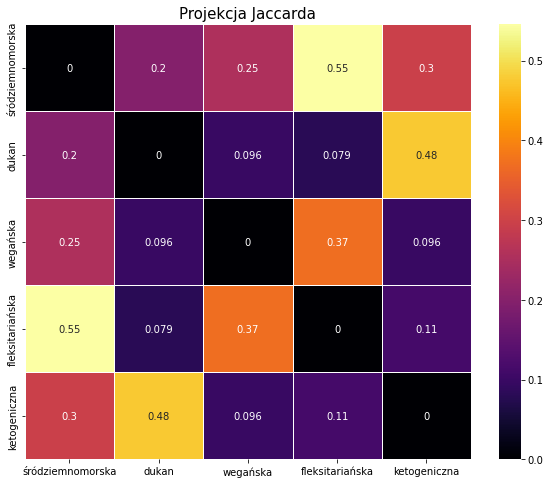

In [139]:

titles = ['Projekcja ważona', 'Projekcja Newmana', 'Projekcja Jaccarda']
for index, weights in enumerate([weighted_projection_matrix, newman_projection_matrix, jaccard_projection_matrix]):
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.heatmap(weights, annot=True, xticklabels=diet_names, yticklabels=diet_names, ax=ax, linewidth=.5, cmap='inferno')
    ax.set_title(titles[index], fontsize=15)

    # plt.tight_layout()
    plt.show()

# plt.subplots_adjust(hspace=0.2)
# plt.show()